In [1]:
import Ipynb_importer
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from model import AlexNet_v1,AlexNet_v2
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 指定使用CPU

2022-03-18 15:48:49.020652: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


importing Jupyter notebook from model.ipynb


In [2]:
"""
定义超参数
"""
im_height = 224
im_width = 224
epoch_num = 15
lr = 0.0005
batch_size = 64

In [3]:
"""
获取数据
"""

# 声明data路径
data_root = "./data"

train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')

# 构造数据生成器（with data augmentation）
'''
keras图像预处理－ImageDataGenerator
1.ImageDataGenerator()是keras.preprocessing.image模块中的图片生成器，
同时也可以在batch中对数据进行增强，扩充数据集大小，增强模型的泛化能力。比如进行旋转，变形，归一化等等。
2.rescale: 重缩放因子。
（1）默认为 None。如果是 None 或 0，不进行缩放，否则将数据乘以所提供的值（在应用任何其他转换之前）。
（2）rescale的作用是对图片的每个像素值均乘上这个放缩因子，这个操作在所有其它变换操作之前执行，在一些模型当中，
直接输入原图的像素值可能会落入激活函数的“死亡区”，因此设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
3.horizontal_flip: 布尔值。随机水平翻转。
'''
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_image_generator = ImageDataGenerator(rescale=1./255)

'''
flow_from_directory:
class_mode: "categorical", "binary", "sparse"或None之一. 默认为"categorical. 该参数决定了返回的标签数组的形式,:
(1)"categorical"会返回2D的one-hot编码标签;
(2)"binary"返回1D的二值标签;
(3)"sparse"返回1D的整数标签;
(4)如果为None则不返回任何标签, 生成器将仅仅生成batch数据, 
这种情况在使用model.predict_generator()和model.evaluate_generator()等函数时会用到.
'''
train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                          batch_size = batch_size,
                                                          shuffle=True,
                                                          target_size = (im_height, im_width),
                                                          class_mode='categorical')
train_num = train_data_gen.n # 训练集中的图像数目:3887

val_data_gen = val_image_generator.flow_from_directory(directory = val_dir,
                                                          batch_size = batch_size,
                                                          shuffle=False,
                                                          target_size = (im_height, im_width),
                                                          class_mode='categorical')
val_num = val_data_gen.n # 验证集中的图像数目:430

print("using {} images for training, {} images for validation.".format(train_num, val_num))


# 获取标签并保存至本地
class_dict = train_data_gen.class_indices # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
class_dict = dict((v, k) for k,v in class_dict.items())# {0:'daisy', 1:'dandelion', 2:'roses' 3:'sunflower' 4:'tulips'}
# write dict into json file
with open('class_indices.json', 'w') as json_file:
    json.dump(class_dict, json_file, indent=4)
    

# 创建文件夹保存模型参数
save_path = "save_weights"
if not os.path.exists(save_path):
    os.makedirs(save_path)

Found 3887 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
using 3887 images for training, 430 images for validation.


[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


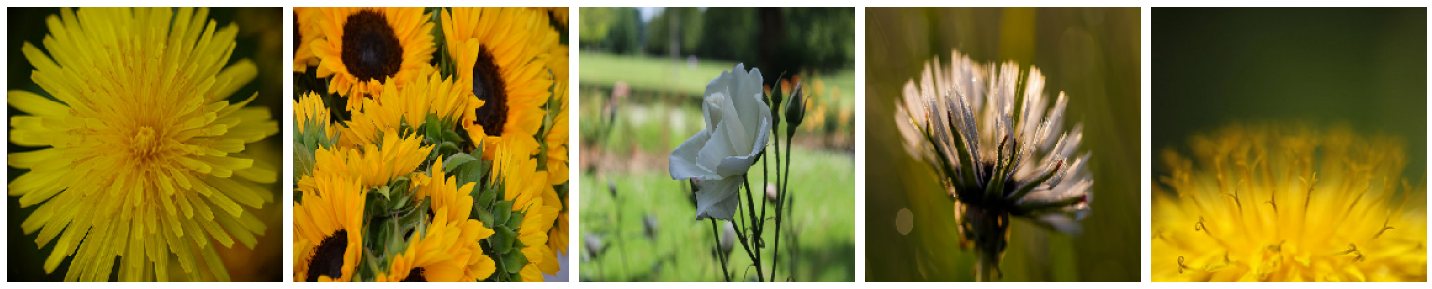

In [4]:
"""
展示图片数据
"""
train_imgs_batch, train_labels_batch = next(train_data_gen)


def plotImgs(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

plotImgs(train_imgs_batch[:5])
'''
注：通过ImageDataGenerator函数获取的图像生成器，会自动将图像label转为one-hot编码格式
'''
print(train_labels_batch[:5])

In [5]:
def showAcc(epoch_num, train_acc,val_acc):
    plt.figure()
    plt.plot(range(epoch_num),train_acc,label="train_acc")
    plt.plot(range(epoch_num),val_acc,label="val_acc")
    plt.xlabel("epochs")
    plt.ylabel("Acc")
    plt.title('Accurary:AlexNet in flowers')
    plt.xticks([i for i in range(0,epoch_num,20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/AccOfAlexNet_cpu.jpg")
    return
def showLoss(epoch_num, train_loss,val_loss):
    plt.figure()
    plt.plot(range(epoch_num),train_loss,label="train_loss")
    plt.plot(range(epoch_num),val_loss,label="val_loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Loss:AlexNet in flowers')
    plt.xticks([i for i in range(0,epoch_num,20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/LossOfAlexNet_cpu.jpg")
    return

# Using keras high level api for traing

In [6]:
def main1():
    """
    获取模型1实例
    """
    model = AlexNet_v1(im_height, im_width, 5)
    model.summary()

    """
    【using keras high level api for traing】
    model.compile详解：https://blog.csdn.net/yunfeather/article/details/106461754
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                 metrics=["accuracy"])
    
    """
    0.callbacks详解：https://www.cnblogs.com/xiximayou/p/12689955.html
    1.save_best_only=True:指标表现最佳时才执行保存模型参数操作（指标—monitor='val_losss'，即当val_loss最小时保存）；
    2.save_weights_only=True：只保留模型参数，体积较小
    （1）为False时表示既保存参数还保存模型架构，体积较大；
    （2）只保留参数时，后续想要迁移该参数，需要重新定义模型，然后加载该参数；
    （3）既保存参数还保存模型架构时，后续可直接加载该保存文件，返回model。
    """
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./save_weights/myAlexNet_cpu.h5',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   monitor='val_loss')]

    history = model.fit(x=train_data_gen,
                     steps_per_epoch=train_num // batch_size,
                     epochs=epoch_num,
                     validation_data=val_data_gen,
                     validation_steps=val_num // batch_size,
                     callbacks=callbacks)
    
    """
    plot losss and accuracy image
    """
    history_dict = history.history
    train_loss = history_dict['loss']
    train_accuracy = history_dict['accuracy']
    val_loss = history_dict['val_loss']
    val_accuracy = history_dict['val_accuracy']
    
    showAcc(epoch_num=epoch_num, train_acc=train_accuracy, val_acc=val_accuracy)
    showLoss(epoch_num=epoch_num, train_loss=train_loss, val_loss=val_loss)

2022-03-18 15:48:52.047657: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-18 15:48:52.075314: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 15:48:52.075347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hzau
2022-03-18 15:48:52.075353: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hzau
2022-03-18 15:48:52.075418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-03-18 15:48:52.075440: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-03-18 15:48:52.075446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-03-18 15:48:52.075708: I tensorflow/core/platform/cpu_feature_guard.c

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 48)        17472     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 192)      

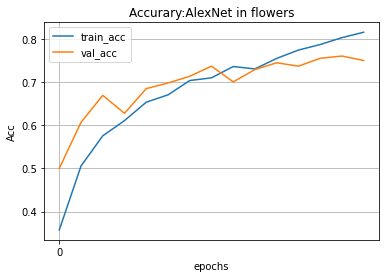

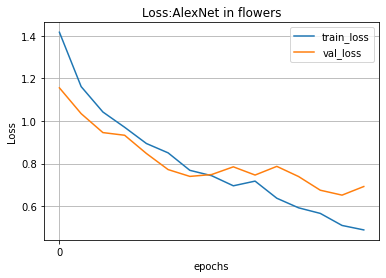

In [7]:
main1()

# Using keras low level api for traing

In [8]:
"""
定义绘图参数
"""
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

"""
获取模型2实例
注：Using keras high level api for traing 或 Using keras low level api for traing与用模型1还是模型2无关
此处只是分别使用一下两种模型进行实例化进行演示（即此处也可继续使用模型1实例化对象）
"""
model = AlexNet_v2(num_classes=5)
model.build((batch_size, im_height, im_width, 3))
model.summary()

"""
定义损失函数
SparseCategoricalCrossentropy讲解 :http://www.360doc.com/content/22/0109/12/32196507_1012511560.shtml
"""
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
"""
定义优化器
"""
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

"""
定义训练过程每一轮loss和accuracy的计算方法
"""
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

"""
定义测试过程每一轮loss和accuracy的计算方法
"""
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Model: "alex_net_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 6, 6, 128)           945856    
_________________________________________________________________
sequential_1 (Sequential)    (64, 5)                   4851461   
Total params: 5,797,317
Trainable params: 5,797,317
Non-trainable params: 0
_________________________________________________________________


In [9]:
"""
@tf.function装饰器（构造高效的python代码）
将python代码转为tensorflow的图结构，能够在GPU、TPU上运算
详解：https://www.bilibili.com/read/cv12856573
"""
# 定义训练函数
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradient = tape.gradient(loss, model.trainable_variables)#将loss反向传播到模型中每一个可训练参数中
    optimizer.apply_gradients(zip(gradient, model.trainable_variables)) #根据梯度更新可训练参数的值
    
    train_loss(loss) # 计算该epoch的loss
    train_accuracy(labels, predictions) #计算该epoch的准确率

# 定义测试函数(注：测试过程不需要进行反向传播)
@tf.function
def test_step(images, labels):
    predictions = model(images)
    loss = loss_object(labels, predictions)
    
    test_loss(loss) # 计算该epoch的loss
    test_acc = test_accuracy(labels, predictions) #计算该epoch的准确率

In [10]:
# 定义main()函数
def main2():
    best_test_acc = 0.0
    for epoch in range(epoch_num):
        # 清零
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for step in range(train_num // batch_size):
            images, labels = next(train_data_gen)
            train_step(images, labels)
        
        # 记录当前epoch下训练过程的accuracy和loss，为绘图做准备
        train_acc_list.append(train_accuracy.result())
        train_loss_list.append(train_loss.result())

        for step in range(val_num // batch_size):
            images, labels = next(val_data_gen)
            test_step(images, labels)
            
        # 记录当前epoch下验证过程的accuracy和loss，为绘图做准备
        val_acc_list.append(test_accuracy.result())
        val_loss_list.append(test_loss.result())
        
        
        template = "Epoch:{}\nTrain Loss:{}, Train Accuracy:{}%\nTest Loss:{}, Test Accuracy:{}%."
        print(template.format(
            epoch + 1,
            train_loss.result(),
            train_accuracy.result() * 100,
            test_loss.result(),
            test_accuracy.result() * 100
        ))
    
        if test_accuracy.result() > best_test_acc:
            best_test_acc = test_accuracy.result()
            model.save_weights("./save_weights/myAlexNet.ckpt", save_format='tf')
    
    print(f"[Best Test Accuracy]:{(best_test_acc * 100):3f}%")
    showAcc(epoch_num=epoch_num, train_acc=train_acc_list, val_acc=val_acc_list)
    showLoss(epoch_num=epoch_num, train_loss=train_loss_list, val_loss=val_loss_list)

In [11]:
# main2()